# Test daily training

## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import datetime
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import load_model

## Hyperparameter

In [3]:
PATH_DF_02 = '/home/ubuntu/github/airflow-automation/02_df/df_train.pkl'
PATH_DF_03 = '/home/ubuntu/github/airflow-automation/02_df/df_vali.pkl'
PATH_DF_04 = '/home/ubuntu/github/airflow-automation/02_df/df_test.pkl'
PATH_MODEL = '/home/ubuntu/github/airflow-automation/03_model/nn.h5'
PATH_SCALER = '/home/ubuntu/github/airflow-automation/03_model/scaler.pkl'

MONITORING = 50

plt.style.use('default')

## Function

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    return float(np.mean(np.abs((y_true - y_pred) / y_true)))

## Model

In [5]:
model_no_training = load_model(PATH_MODEL)
model_daily_training = load_model(PATH_MODEL)

## Scaler

In [6]:
scaler_no_update = pickle.load(open(PATH_SCALER, 'rb'))
scaler_update = pickle.load(open(PATH_SCALER, 'rb'))

## Training data

In [7]:
df_train = pickle.load(open(PATH_DF_02, 'rb'))
df_vali = pickle.load(open(PATH_DF_03, 'rb'))
df_model = df_train.append(df_vali)
df_model = df_model.sort_index()

In [8]:
df_model.head(2)

,load,temp_f,year,month,day,hour,dow
period,,,,,,,
2015-07-01 01:00:00,4875.0,68.77544,2015,7,1,1,2
2015-07-01 02:00:00,4618.0,66.80714,2015,7,1,2,2


In [9]:
df_model.tail(2)

,load,temp_f,year,month,day,hour,dow
period,,,,,,,
2019-06-30 22:00:00,6275.0,65.5844,2019,6,30,22,6
2019-06-30 23:00:00,5829.0,65.3693,2019,6,30,23,6


## Test data

In [10]:
df_test = pickle.load(open(PATH_DF_04, 'rb'))

In [11]:
df_test.head(2)

,load,temp_f,year,month,day,hour,dow
period,,,,,,,
2019-07-01 00:00:00,5431.0,65.52248,2019,7,1,0,0
2019-07-01 01:00:00,5092.0,64.82696,2019,7,1,1,0


In [12]:
df_test.tail(2)

,load,temp_f,year,month,day,hour,dow
period,,,,,,,
2020-08-02 08:00:00,4642.0,NaN,2020,8,2,8,6
2020-08-02 09:00:00,4918.0,NaN,2020,8,2,9,6


## For loop of prediction and training

In [13]:
# initialize
slicer = df_test.index[0]
end = df_test.index[-1]
# print(slicer, end)
X_scaler_base = df_model[['temp_f', 'year', 'month', 'day', 'hour', 'dow']]
counter = 0

while (slicer < end):
    
    # prepare input
    tmp = df_test.loc[(df_test.index >= slicer) & (df_test.index < slicer + datetime.timedelta(hours = 24))]
    y = tmp.pop('load')
    X = tmp

    # preprocess
    X_scaled = scaler_update.transform(X)

    # prediction
    y_pred = model_daily_training.predict(X_scaled)

    # training
    history = model_daily_training.fit(X_scaled, y, epochs = 1, verbose = 0)

    # update scaler
    X_scaler_base = X_scaler_base.append(X)
    scaler_update.fit(X_scaler_base)

    # store prediction
    if counter == 0:
        y_preds = y_pred
    elif counter != 0:
        y_preds = np.concatenate((y_preds, y_pred), axis = 0)

    # update slicer
    slicer = slicer + datetime.timedelta(hours = 24)
    
    # monitoring
    if (counter % MONITORING) == 0:
        print(counter)
    
    # update counter
    counter += 1

0
50
100
150
200
250
300
350


## Forecast from model without daily training

In [14]:
X = df_test.copy()
X = X[['temp_f', 'year', 'month', 'day', 'hour', 'dow']]
X_scaled = scaler_no_update.transform(X)
y_preds_no_training = model_no_training.predict(X_scaled)

## Merge

In [15]:
df_pred = df_test.copy()
df_pred['forecast_load_daily_training'] = y_preds
df_pred['forecast_load_no_training'] = y_preds_no_training
df_pred = df_pred.dropna()

In [19]:
df_pred.head(2)

,load,temp_f,year,month,day,hour,dow,forecast_load_daily_training,forecast_load_no_training
period,,,,,,,,,
2019-07-01 00:00:00,5431.0,65.52248,2019,7,1,0,0,4821.153809,4821.153809
2019-07-01 01:00:00,5092.0,64.82696,2019,7,1,1,0,4665.995605,4665.995605


In [18]:
df_pred.tail(2)

,load,temp_f,year,month,day,hour,dow,forecast_load_daily_training,forecast_load_no_training
period,,,,,,,,,
2020-07-31 13:00:00,6705.0,84.5801,2020,7,31,13,4,6826.143066,6566.851562
2020-07-31 14:00:00,7083.0,86.6285,2020,7,31,14,4,7213.638184,6919.905762


## Evaluation

In [22]:
rmse_training = np.sqrt(mean_squared_error(df_pred['load'], df_pred['forecast_load_daily_training']))
mae_training = mean_absolute_error(df_pred['load'], df_pred['forecast_load_daily_training'])
mape_training = mean_absolute_percentage_error(df_pred['load'], df_pred['forecast_load_daily_training'])

rmse_no = np.sqrt(mean_squared_error(df_pred['load'], df_pred['forecast_load_no_training']))
mae_no = mean_absolute_error(df_pred['load'], df_pred['forecast_load_no_training'])
mape_no = mean_absolute_percentage_error(df_pred['load'], df_pred['forecast_load_no_training'])

print('Daily trian model')
print('RMSE: {:.1f} MW, MAE: {:.1f} MW, MAPE: {:.1%}'.format(rmse_training, mae_training, mape_training))
print('\nFix model over horizon')
print('RMSE: {:.1f} MW, MAE: {:.1f} MW, MAPE: {:.1%}'.format(rmse_no, mae_no, mape_no))

Daily trian model
RMSE: 362.8 MW, MAE: 268.4 MW, MAPE: 4.6%

Fix model over horizon
RMSE: 551.6 MW, MAE: 443.8 MW, MAPE: 7.6%


## Shape of load

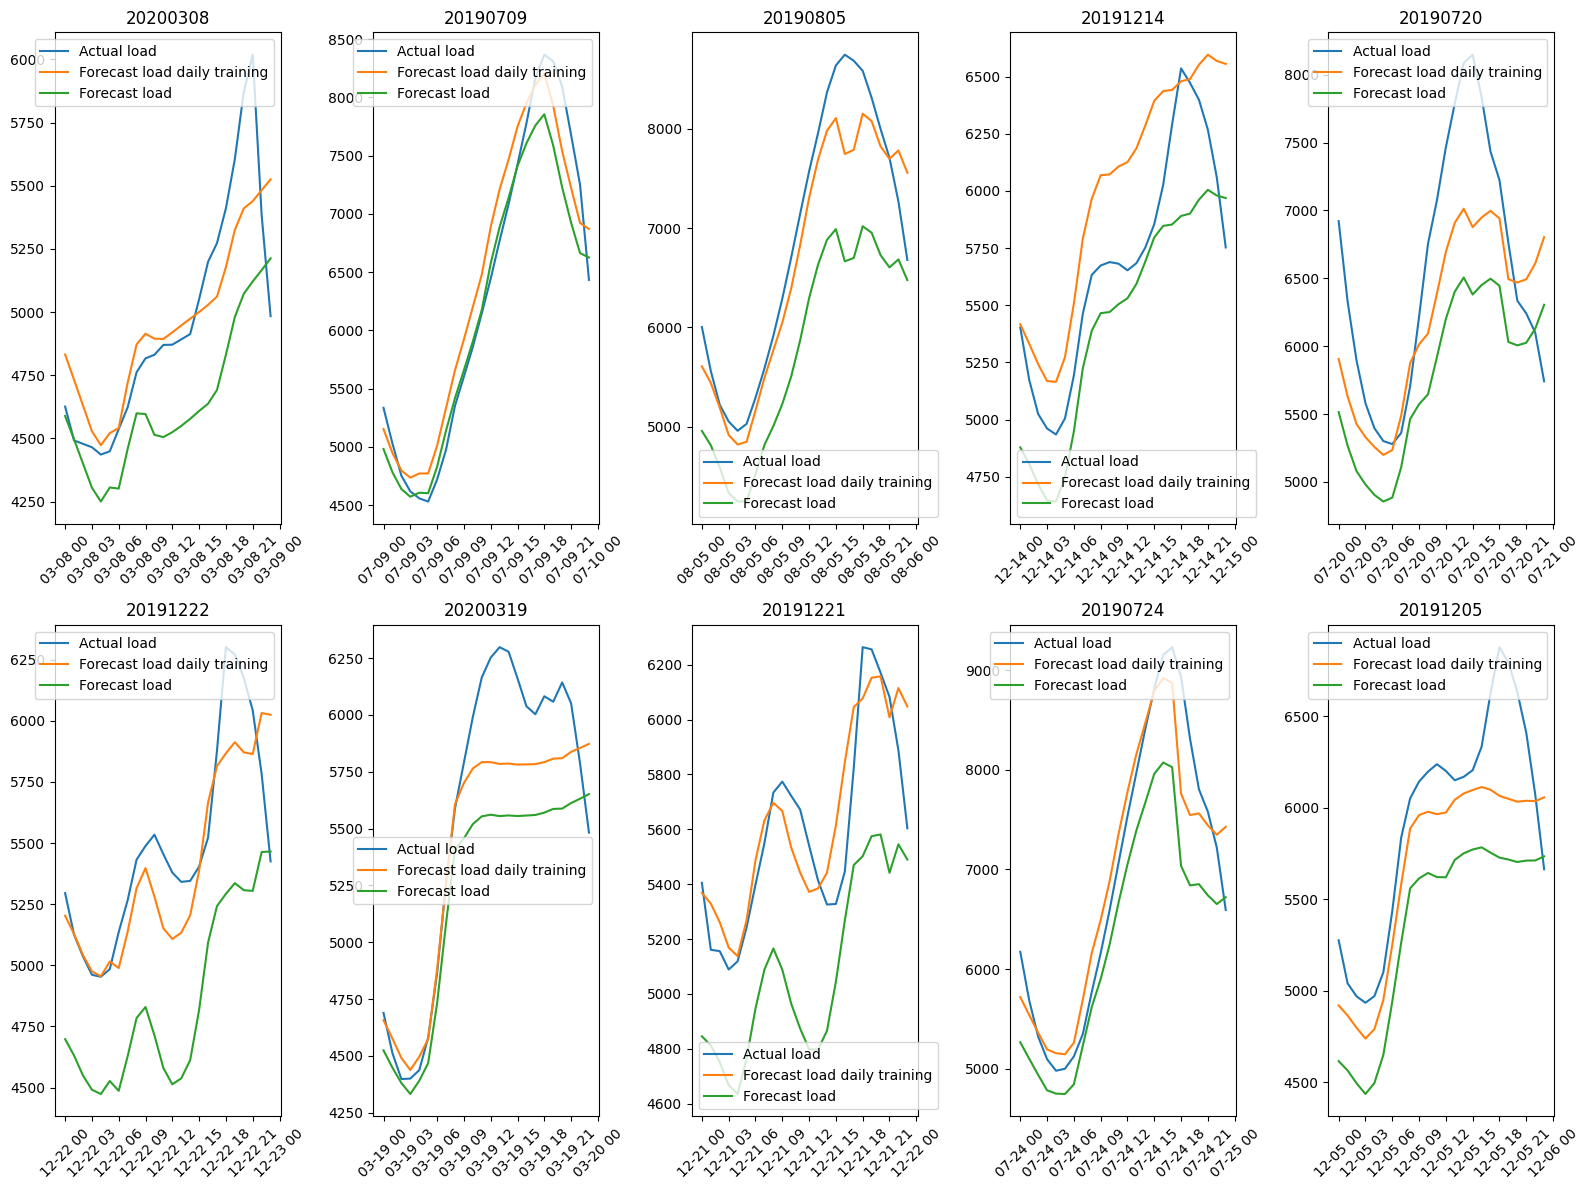

In [23]:
dates = np.random.choice(df_pred.index, 10)

plt.figure(figsize = (8*2, 6*2))
for i, date in enumerate(dates):
    date = pd.to_datetime(date)
    plt.subplot(2, 5, i+1)
    plt.plot(df_pred[date.strftime('%Y%m%d')]['load'], label = 'Actual load')
    plt.plot(df_pred[date.strftime('%Y%m%d')]['forecast_load_daily_training'], label = 'Forecast load daily training')
    plt.plot(df_pred[date.strftime('%Y%m%d')]['forecast_load_no_training'], label = 'Forecast load')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.title(date.strftime('%Y%m%d'))
    
plt.tight_layout()
plt.show()